## Trading in Kraken Exchange with a Deep Deterministic Policy Gradient (DDPG) Agent

- The purpose of this notebook is to help the user understand how to train the RL Agent to trade in the kraken Exchange
- The actor and critic networks are two deep neural networks.  The actor $A_t$ outputs the optimal policy to trade a portfolio of securities.  The critic network $Q_t$ estimates how good the action the actor $A_t$ took.  We call an agent that combines these two networks a __DDPG Agent__
- We will compare the performance between two types of agents:
    - __DDPG Agent__ who allocates capital dynamically among the assets in his portfolio
    - __Buy and Hold Agent__ who allocates equal weights among the assets in his portfolio.
- In order to train the DDPG Agent, we will split the data into two halves: a train set and a test to evaluate the performance of the learned model

## Assets in Portfolio
- There are 7 assets
- The assets in portfolio are composed of "CASH", "SOL", "PEPE", "ETH", "TRX", "MATIC", "LINK"

## Portfolio Rebalancing Set-Up
- We trade every $\Delta_t = 30$ minutes.  This is rebalancing interval
- Time interval is composed of open, high low and close prices in that interval
- At time t = 0, at the open, we start with a portfolio composed of only cash given by $w_0 = (1, 0, 0, 0, 0, 0, 0)$
- The actor at same time t, $A_t$ then suggests a policy given by $w_1 = (w_1^0, w_1^1, w_1^2, ..., w_1^7)$ to be allocated at time t = 1.  This is determined by the neural network
- Market movements from $t=0$ at open to t=0 at close causes portfolio value to change from $\pi_0$ to $\pi_{0}^{'}$
- At time t = 0, at the close, we purchase these assets and calculate reward $r_0$
- We repeat this process until we reach the end of the episode. 

## Assumptions and tensor set-up
- No Market Impact since the quantity traded is so small
- price tensor $X_t$ is of shape 6 non cash coins with a look-back period of 2 days.  These are relative prices that are divided by the latest closing price and correspond to 3 features, open, high and close.  Hence $X_t \in R^{(3, 6, 100)}$
- state at time $t$, denoted $s_t = (X_t, w_{t-1})$
- Transaction cost is 0.18% which uses the transaction remainder factor $u_t$ as suggested in https://arxiv.org/abs/1706.10059
- We will use a batch size of 128 samples to sample from the Priority Replay Buffer

## Agent-Environment Interaction
- When calling train(numEpisodes) function on the __ddpg_agent__ object below, the agent interacts with the environment in an episodic manner:
    - He observes the state $s_t = (X_t,w_{t-1})$, 
    - takes action $w_t = \pi(s_t)$, 
    - receives reward $r_t$ and 
    - makes transition to next state $s_{t+1} = (X_{t+1},w_t)$.  
- Store the interactions in a replay Buffer as a tuple given by $(s_t, a_t, r_t, s_{t+1})$.  
- Run the above algorithm for 5000 warm-up steps, once the buffer is filled with enough diversity, we sample a batch of 128 from this buffer to train the actor and critic networks.  
- Repeat the above process until episode termination.  

## Transaction Cost Model
- As specified in the paper, we use the transaction remainder factor to determine the remaining portfolio value due to buying and selling

## Priority Replay Buffer
- We store agent interactions into a replay buffer in order to train the actor and critic networks.  We use a warm up steps of 5000 steps.

## Exploration Strategy
- The agent class supports three types of exploration strategies, given by "greedy", "hybrid" and "ou"
- The "greedy" strategy implements the epsilon greedy algorithm.  In here, we start with exploration phase and decay epsilon exponentially until a set number of warm up steps have reached within an episode.  Once the warm up stage is over, agent completely exploits
- the "ou" exploration performs an ornstein-oulenbeck" exploration strategy.  The exploration is smooth.  We initially start with a $\sigma = 40%$.  Then gradually decay this during the episode until a minimum 5-10% is left.  We still continue to explore albeit exploit more
- the "hybrid" strategy combines both the greedy-epsilon strategy and "ou" strategy.  We start with complete epsilon greeedy until a warm up phase is reached, then after perform a ou exploration for smooth exploration.  
- In this notebook, we will use a "ou" method to showcase a particular result

## Reward function with transaction cost
- the reward function $r_t$ is given by $r_t = log(u_t*y_t w_{t-1})$
- We award the agent for taking good actions rather than penalizing him for bad actions.  This is given by:

$r_t^p = r_t + \alpha \sum_j^7 w_{t-1}^j * ReLU(y_t^j - 1)$ 

## Portfolio Value
- The portfolio value at time t, $\pi_t$ is given by $\pi_t = \pi_{t-1} * e^{r_t^p}$
- This is accomplished by the agent.build_equity_curve() function that interacts with the environment and computes the resulting equity curve which incorporates transaction cost


Actor Network

## Import Necessary Libraries
- We will start with importing necessary libraries to build this agent environment interaction
- We import a portfolio class because an agent has a portfolio whose return he seeks to maximize.  
- The portfolio class downloads the historical data for the time period in question for each asset 
- When calling a DDPG Agent, it encapsulates the agent environment interaction.  
= To create this agent environment interaction, an environment class was created which encapsulates the dataclass object provided by pytorch.  
- The logic for creating price tensors has been abstracted away from the user.  This is located in the KrakenDataSet class object.  
- The TradeEnv Class encapsulates the KrakenDataSet and uses the price tensor created there to step through the environment.  

In [1]:

import numpy as np 
import torch
import matplotlib.pyplot as plt
from typing import List
from ddpgportfolio.agent import DDPGAgent, BuyHoldAgent
from ddpgportfolio.portfolio.portfolio import Portfolio

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059

torch.set_default_device("mps")


INITIAL_CASH = 10000
BATCH_SIZE = 128  # training is done in mini-batches
WINDOW_SIZE = 100  # last 100 time steps in price tensor, so this reflects 2 days worth of look back
STEP_SIZE = 1  # for rolling window batch sampler
train_start_date = "2024-01-01"  # start date of trading
train_end_date = "2024-07-30"
test_start_date = "2024-08-01"
test_end_date = "2024-09-30"
N_EPISODES = 6  # number of episodes to train the agent
DEVICE = "mps"

asset_names: List[str] = ["CASH", "SOL", "PEPE", "ETH", "TRX", "MATIC", "LINK"]


train_port = Portfolio(asset_names=asset_names, start_date=train_start_date, end_date=train_end_date, initial_cash=INITIAL_CASH)
test_port = Portfolio(asset_names=asset_names, start_date=test_start_date, end_date=test_end_date, initial_cash=INITIAL_CASH)



### Equity Curve for Buy and Hold Agent
- Below is the Equity Curve for a Buy and Hold Agent who has 20% allocated to cash and the other 80% allocated to non cash coins.  The Equity curve uses the out of sample test set from 2024-08-01 till 2024-09-31

In [3]:
bh_agent = BuyHoldAgent(test_port, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, cash_weight=0.2, device=DEVICE)
bh_equity_curve = bh_agent.build_equity_curve()

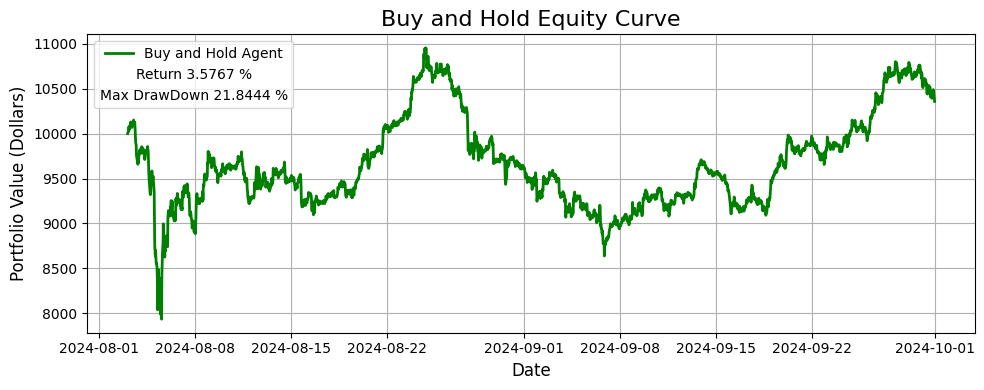

In [4]:
import matplotlib.offsetbox as offsetbox
cl_price = test_port.get_close_price()
dates = cl_price.index
bh_return = bh_agent.portfolio.calculate_final_equity_return(bh_equity_curve)
bh_mdd = bh_agent.portfolio.calculate_max_drawdown(bh_equity_curve)


plt.figure(figsize=(10, 4))
plt.grid()
plt.plot(dates[WINDOW_SIZE:], bh_equity_curve, label="Buy and Hold Agent", linewidth=2, color='green');
plt.title("Buy and Hold Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (Dollars)", fontsize=12)

#plt.legend(loc='best');
a = plt.legend(loc='best')

txt1=offsetbox.TextArea(f"Return {bh_return:.4f} %")
txt2=offsetbox.TextArea(f"Max DrawDown {bh_mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt1)
box.get_children().append(txt2)

box.set_figure(box.figure)
plt.tight_layout()



## DDPG Agent
- Now we will trian the DDPG Agent and plot the same equity curve

In [5]:
ddpg_agent = DDPGAgent(train_port, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, device=DEVICE)

In [6]:
# train agent with ornstein-uhlenbeck exploration strategy
ddpg_agent.train(6, action_type="ou");

Training Started for DDPG Agent
time-step: 6000, batch actor loss: -0.012147367853749464, batch critic loss: 0.8236067373376269
time-step: 8000, batch actor loss: -0.013423043887867346, batch critic loss: 0.7453882738833664
time-step: 10000, batch actor loss: -0.013880026409798409, batch critic loss: 0.6996638762655317
Episode 1 - Avg Actor Loss: -0.0139, Avg Critic Loss: 0.6988, True Episodic Reward: 0.4551
time-step: 2000, batch actor loss: -0.015160711846780032, batch critic loss: 0.5829600909501315
time-step: 4000, batch actor loss: -0.015791051375912503, batch critic loss: 0.5923138690516353
time-step: 6000, batch actor loss: -0.015917811857225996, batch critic loss: 0.591994422716399
time-step: 8000, batch actor loss: -0.01643600322015118, batch critic loss: 0.59150972626172
time-step: 10000, batch actor loss: -0.01691447802884504, batch critic loss: 0.5921520251438022
Episode 2 - Avg Actor Loss: -0.0169, Avg Critic Loss: 0.5920, True Episodic Reward: -0.3910
time-step: 2000, bat

## Equity Curve for DDPG Agent
- Evaluate the agent's performance on the test portfolio

In [6]:
ddpg_equity_curve = ddpg_agent.build_equity_curve(test_port)

In [8]:
len(ddpg_equity_curve), len(dates[WINDOW_SIZE:]), len(test_port.get_close_price())

(2908, 2907, 2927)

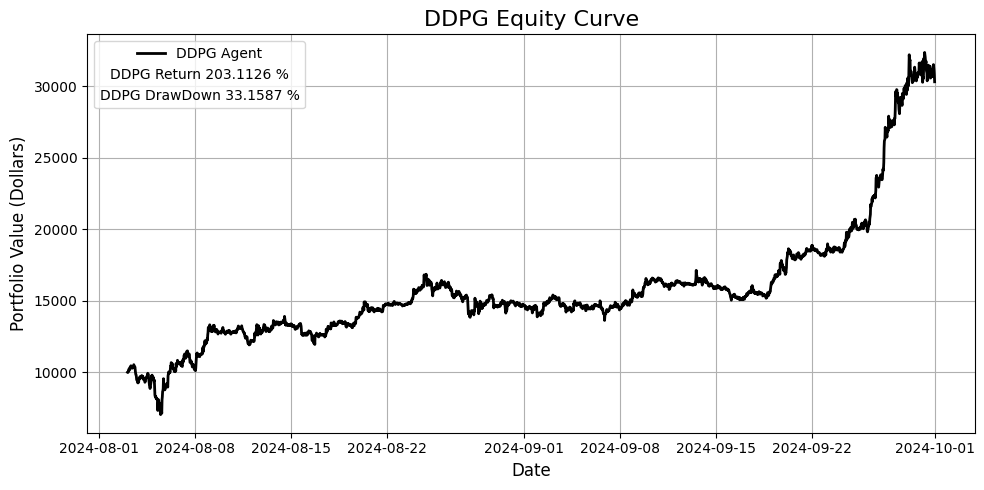

In [7]:
cl_price = test_port.get_close_price()
dates = cl_price.index
ddpg_return = ddpg_agent.portfolio.calculate_final_equity_return(ddpg_equity_curve[:-1])
ddpg_mdd = ddpg_agent.portfolio.calculate_max_drawdown(ddpg_equity_curve[:-1])


plt.figure(figsize=(10, 5))
plt.plot(dates[WINDOW_SIZE:], ddpg_equity_curve[:-1], label="DDPG Agent", linewidth=2, color='black');
#plt.plot(dates[10:], np.log(bh_equity_curve), label="Buy and Hold Agent", linewidth=2, color='b');
plt.title("DDPG Equity Curve", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Portfolio Value (Dollars)", fontsize=12)

#plt.legend(loc='best');
a = plt.legend(loc='best')

txt1=offsetbox.TextArea(f"DDPG Return {ddpg_return:.4f} %")
txt2=offsetbox.TextArea(f"DDPG DrawDown {ddpg_mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt1)
box.get_children().append(txt2)

box.set_figure(box.figure)
plt.tight_layout()
plt.grid()

## Uncomment the following lines of code to save and load the agent

In [148]:
import pickle
with open("ddpg_agent_run13.pkl", "wb") as f:
    pickle.dump(ddpg_agent, f)

In [5]:
import pickle
with open("ddpg_agent_run13.pkl", "rb") as f:
    ddpg_agent = pickle.load(f)


## Reward and Policy Evaluation Experiments

In [8]:
rewards = [exp.reward for exp in ddpg_agent.replay_memory.buffer]

Reward Min: -12.84213566569499, Reward Max: 18.656974015791196
Reward Mean: 0.01825684667051638, Reward Std: 1.009095002543371


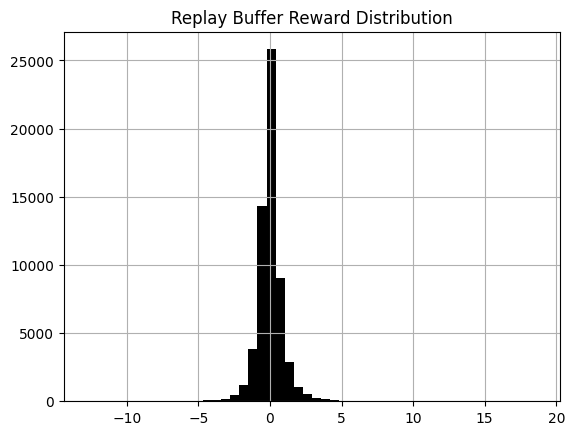

In [9]:
import matplotlib.pyplot as plt
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50, color='black')
plt.title("Replay Buffer Reward Distribution")

plt.grid()

### Decay of Sigma for smoother Exploration

Text(0, 0.5, 'Sigma')

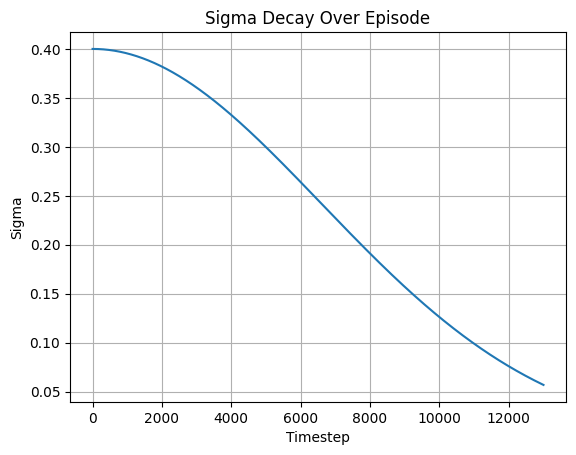

In [10]:
import matplotlib.pyplot as plt
import numpy as np

sigma_values = []
sigma = 0.4  # Initial sigma
decay_rate_within_episode = 0.0003
min_sigma = 0.05
n_samples = 13_000

for t in range(1, n_samples + 1):
    dt = t / n_samples
    sigma = max(sigma * np.exp(-dt * decay_rate_within_episode), min_sigma)
    sigma_values.append(sigma)

plt.plot(range(1, n_samples + 1), sigma_values)
plt.grid();
plt.title("Sigma Decay Over Episode")
plt.xlabel("Timestep")
plt.ylabel("Sigma")


In [18]:
len(ddpg_agent.actions)

2828

## Changes in Allocations over time
- Notice the changes in allocations over time for the ddpg agent

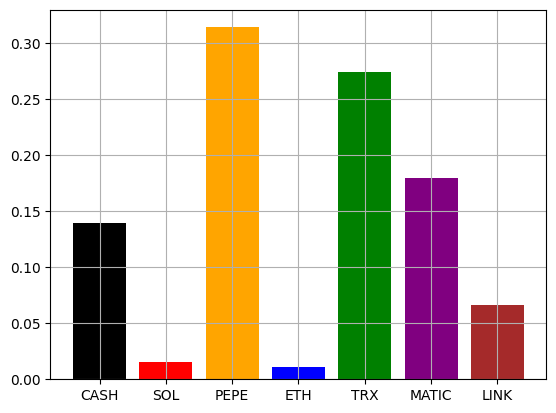

In [12]:
plt.bar(asset_names, ddpg_agent.actions[994].cpu().numpy(),
        color=['black', 'red', 'orange', 'blue', 'green', 'purple', 'brown'])
plt.grid()

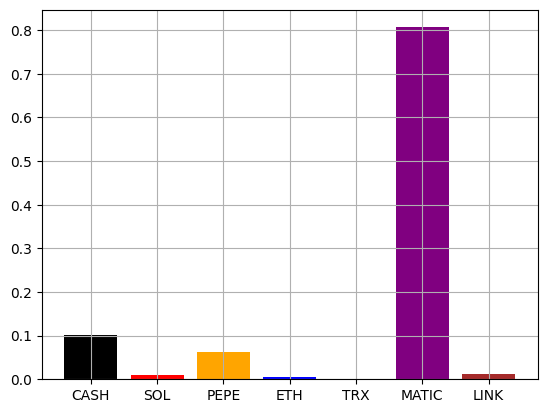

In [13]:
plt.bar(asset_names, ddpg_agent.actions[2000].cpu().numpy(), 
        color=['black', 'red', 'orange', 'blue', 'green', 'purple', 'brown'])
plt.grid()

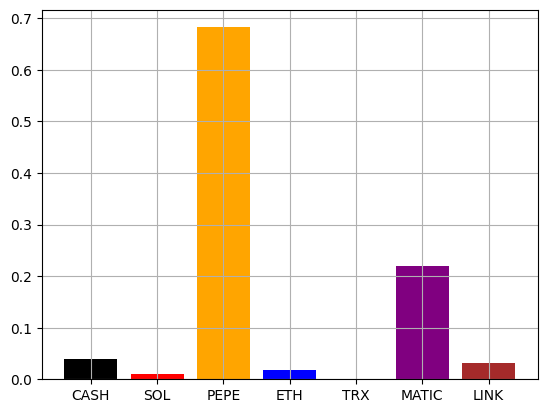

In [14]:
plt.bar(asset_names, ddpg_agent.actions[2200].cpu().numpy(), 
        color=['black', 'red', 'orange', 'blue', 'green', 'purple', 'brown'])
plt.grid()

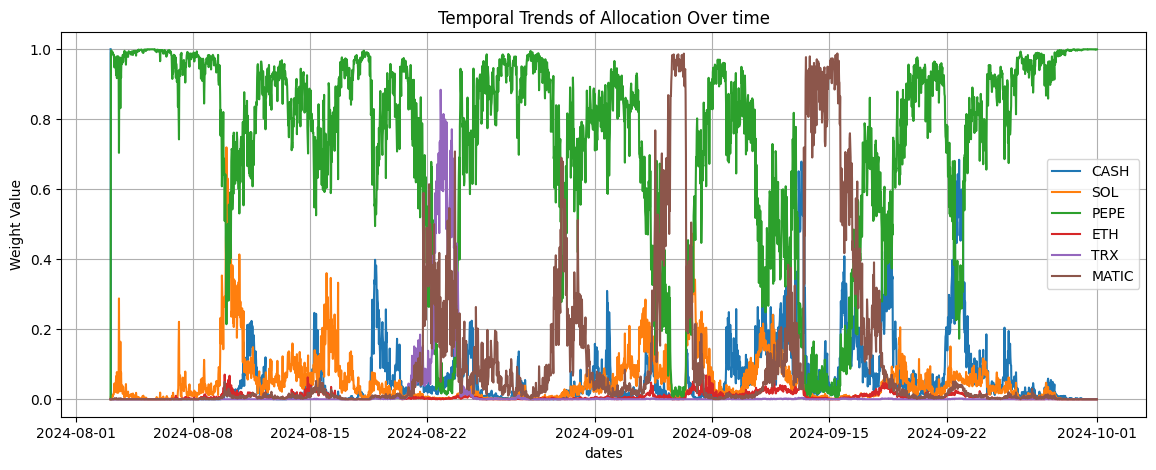

In [15]:
def zero_small_values(tensor, threshold=1e-3):
    return torch.where(torch.abs(tensor) < threshold, torch.zeros_like(tensor), tensor)

actual_actions = torch.stack([action for action in ddpg_agent.actions])
actual_actions = zero_small_values(actual_actions)

plt.figure(figsize=(14, 5))
for i in range(6):
    plt.plot(dates[WINDOW_SIZE:], actual_actions[:, i][:-1].cpu().numpy(), label=f"{asset_names[i]}")
plt.title("Temporal Trends of Allocation Over time")
plt.xlabel("dates")
plt.ylabel("Weight Value")
plt.legend()
plt.grid()

In [16]:
sampled_actions = torch.stack([exp.action for exp in ddpg_agent.replay_memory.buffer])
action_variances = torch.var(sampled_actions, dim=0)
print("Action Variance per Dimension:", action_variances)

Action Variance per Dimension: tensor([0.0368, 0.0196, 0.1591, 0.0060, 0.0090, 0.0067, 0.0138],
       device='mps:0')


In [17]:
import pandas as pd
action_correlation = torch.corrcoef(sampled_actions.T)  # Correlation matrix
print("Action Correlation Matrix:")
df = pd.DataFrame(action_correlation.cpu().numpy(), columns=asset_names)
df.index = asset_names
df

Action Correlation Matrix:


,CASH,SOL,PEPE,ETH,TRX,MATIC,LINK
CASH,1.000000,-0.018881,-0.674836,0.247616,0.413799,0.129021,0.093659
SOL,-0.018881,1.000000,-0.433851,0.082411,0.002707,0.131461,0.164853
PEPE,-0.674836,-0.433851,1.000000,-0.600091,-0.627350,-0.535148,-0.501570
ETH,0.247616,0.082411,-0.600091,1.000000,0.462526,0.448892,0.189089
TRX,0.413799,0.002707,-0.627350,0.462526,1.000000,0.320326,0.115644
MATIC,0.129021,0.131461,-0.535148,0.448892,0.320326,1.000000,0.196487
LINK,0.093659,0.164853,-0.501570,0.189089,0.115644,0.196487,1.000000


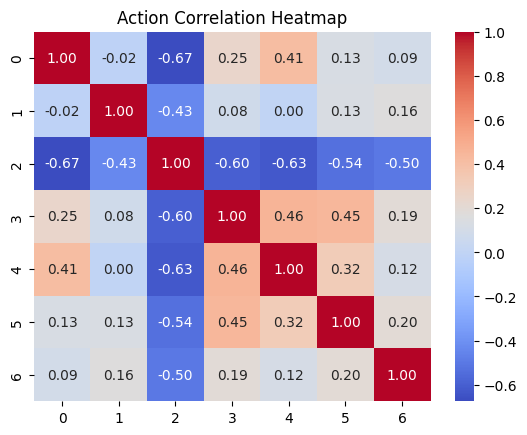

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(action_correlation.cpu().numpy(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Action Correlation Heatmap")
plt.show()